In [3]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
api_key = os.environ.get('binance_key')
api_secret = os.environ.get('binance_secret')

In [5]:
client = Client(api_key, api_secret)

In [18]:
# hyperparams
N = 60 # number of coins
M = 60 # number of time intervals to get data for
X = 20 # the number of principle components to use

#### In this notebook I follow the approach described by Avellaneda and Lee (2010) 

## Part One: Getting and Cleaning Data

In [7]:
# grabbing data for the N highest volume coins that are priced in USD

info = client.get_all_tickers()
all_symbols = [d['symbol'] for d in info]
priced_in_btc = [s for s in all_symbols if 'BTC' in s]

#[s for s in all_symbols if ('USD' in s and (not 'USDT' in s) and (not 'USDC' in s))]

tickers = client.get_orderbook_tickers()
tickers = pd.DataFrame.from_dict(tickers)
col_types = {
    'symbol': 'str',
    'bidPrice': 'float',
    'bidQty': 'float',
    'askPrice': 'float',
    'askQty': 'float',
}
tickers = tickers.astype(col_types)
tickers['totalQty'] = tickers['bidQty'] + tickers['askQty']

high_volume_coins = tickers[tickers['symbol'].isin(priced_in_btc)].nlargest(N, 'totalQty')
symbols = high_volume_coins['symbol'].values



high_volume_coins[:10]

,symbol,bidPrice,bidQty,askPrice,askQty,totalQty
1232,REEFBTC,5.100000e-07,10652679.0,5.200000e-07,27319355.0,37972034.0
1261,CKBBTC,3.000000e-07,12030965.0,3.100000e-07,23435113.0,35466078.0
519,PHBBTC,2.000000e-07,17985471.0,2.100000e-07,16914813.0,34900284.0
357,SCBTC,4.300000e-07,7626960.0,4.400000e-07,26245857.0,33872817.0
243,IOSTBTC,8.900000e-07,13939867.0,9.000000e-07,7052536.0,20992403.0
46,XVGBTC,5.700000e-07,10243697.0,5.800000e-07,3917627.0,14161324.0
181,CNDBTC,3.600000e-07,7748316.0,3.700000e-07,1987154.0,9735470.0
815,STMXBTC,6.800000e-07,6693190.0,6.900000e-07,1953377.0,8646567.0
340,QKCBTC,4.400000e-07,5820202.0,4.500000e-07,2437617.0,8257819.0
37,FUNBTC,6.500000e-07,5482240.0,6.600000e-07,2056476.0,7538716.0


In [8]:
# Constructing a data frame with close price data and volume for each of the N stocks going back M days
'''
# example: fetch 1 minute klines for the last day up until now
klines = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

the 'klines' you get from the api are in the format

Open time,
Open - High - Low - Close - Volume,
Close time,
quote asset volume,
number of trades,
'taker_base_asset_vol', 'taker_quote_asset_vol', 'ignore'


make sure to cast everything to floats

'''

#klines = client.get_historical_klines(high_volume_coins['symbol'].values[0], Client.KLINE_INTERVAL_1DAY, "{} days ago UTC".format(M))


price_histories = {}
for s in high_volume_coins['symbol'].values:
    klines = client.get_historical_klines(s, Client.KLINE_INTERVAL_1DAY, "{} days ago UTC".format(M+1))
    klines = [(lambda l: [float(x) for x in l])(candle) for candle in klines]
    #print(klines)
    history = pd.DataFrame(klines, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'num_trades', 'taker_base_asset_vol', 'taker_quote_asset_vol', 'ignore'])
    price_histories[s] = history

    
for symbol, df in price_histories.items():
    df['symbol'] = [symbol for i in range(len(df.index))]
    df['t'] = [i for i in range(len(df.index))]
    
price_histories[symbols[0]].head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_asset_vol,taker_quote_asset_vol,ignore,symbol,t
0,1.625011e+12,4.500000e-07,4.700000e-07,4.300000e-07,4.500000e-07,78998606.0,1.625098e+12,35.300454,1979.0,44277603.0,19.816172,0.0,REEFBTC,0
1,1.625098e+12,4.500000e-07,4.600000e-07,4.400000e-07,4.500000e-07,77492560.0,1.625184e+12,34.832702,1556.0,34338195.0,15.483719,0.0,REEFBTC,1
2,1.625184e+12,4.400000e-07,4.500000e-07,4.300000e-07,4.400000e-07,51518888.0,1.625270e+12,22.653114,1257.0,20670855.0,9.118773,0.0,REEFBTC,2
3,1.625270e+12,4.400000e-07,4.500000e-07,4.300000e-07,4.400000e-07,38042716.0,1.625357e+12,16.739471,998.0,15967058.0,7.039620,0.0,REEFBTC,3
4,1.625357e+12,4.400000e-07,4.600000e-07,4.200000e-07,4.500000e-07,174856477.0,1.625443e+12,78.009516,2130.0,103427399.0,46.302458,0.0,REEFBTC,4


In [9]:
len(symbols) == N

True

In [10]:
for i in range(N):
    print(i, len(price_histories[symbols[i]]))

0 61
1 61
2 61
3 61
4 61
5 61
6 61
7 61
8 61
9 61
10 61
11 61
12 61
13 61
14 61
15 61
16 61
17 61
18 61
19 61
20 58
21 61
22 61
23 61
24 61
25 61
26 61
27 61
28 61
29 61
30 61
31 61
32 61
33 61
34 61
35 61
36 61
37 61
38 61
39 61
40 61
41 61
42 61
43 61
44 61
45 61
46 61
47 61
48 61
49 61
50 61
51 61
52 61
53 61
54 61
55 61
56 61
57 61
58 61
59 61


In [11]:
# need to remove coins from the universe that dont have M+1 days of data (also update N and M)
# NB: this doesn't seem to be an issue for BTC pairs, just when I was looking at USD pairs

In [12]:
# to do: write a function to make some nice graphs

## Part Two: Using PCA to find Risk Factors

In [19]:
print(N, M)

60 60


In [29]:
# need a matrix S_it with the price of the ith stock at time t

S = np.ones([N, M+1])

for i in range(N):
    history = price_histories[symbols[i]]
    column = history['close'].values
    for j in range(M+1):
        try:
            S[i][j] = column[j]
        except:
            print(i, j)



20 58
20 59
20 60


In [ ]:
# Generating R, the matrix of returns
# R_ik = return of ith stock at time t=k = (S_i_(t_0 - k-1) - S_i_(t_0 - k))/(S_i_(t_0 - k))

def get_returns_from_prices(S, t_0):
    R = np.ones([N, M])

    for i in range(N):
        for j in range(M):
            new_price = S[i][t_0 - j - 1]
            old_price = S[i][t_0 - j]
            R[i][j] = (new_price - old_price) / old_price

    return R
        
R = get_returns_from_prices(S, M)

In [ ]:
# Standardizing the returns as done on page 6 in the paper

R_bar = np.ones([N])

for i in range(N):
    R_bar[i] = np.mean(R[i])

sigma_bar = np.ones([N])

for i in range(N):
    sigma_bar[i] = np.std(R[i])

Y = np.ones([N, M])

for i in range(N):
    Y[i] = (R[i] - R_bar[i]) / sigma_bar[i]

In [ ]:
# Computing the emperical correlation matrix

#rho = np.ones([N, M])

#for i in range(N):
#    for j in range(M):
#        rho[i][j] = np.dot(Y[i], Y[j]) / (M-1)

In [ ]:
# Finding the SVD of the data matrix
# S contains the singular values in descending order, columns of V (<-> rows of V transpose) are the right-singular vectors 

U, S, Vt = np.linalg.svd(Y, hermitian=True)
V = np.transpose(Vt)

#print('S:', S, 'V:', V)

<BarContainer object of 60 artists>

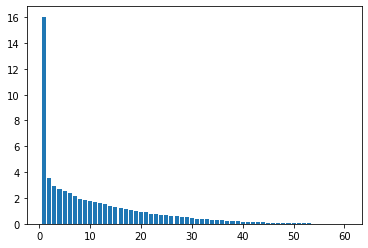

In [ ]:
plt.bar(np.arange(1, len(S)+1, 1), S)

In [ ]:
principal_components = Vt[:X]
eigenvalues = S[:X]

In [ ]:
# Constructing the X eigenportfolios

Q = np.ones([X, N])

for j in range(X):
    Q[j] = principal_components[j] / sigma_bar


In [ ]:
# Calculating the returns for the eigenportfolios

F = np.ones([X, M]) # first dim is which eigenportfolio, second dim is time

R_transpose = np.transpose(R)
for j in range(X):
    for k in range(M):
        F[j][k] = np.dot(Q[j], R_transpose[k])


In [ ]:
#plt.plot(F[0])

In [ ]:
#combined_portfolio = np.sum(Q, axis=0)
#combined_portfolio_returns = np.sum(F, axis=0)

In [ ]:
#plt.plot(combined_portfolio_returns)

In [31]:
#summary = pd.DataFrame(data=np.transpose([symbols, Q[0]]), columns=['Symbol', 'weight in eigenport. #0'])
#summary.head()

# I think I interpreted the output of the SVD wrong, oops! 

## Part Three: Using the Eigenportfolios to Model Coin Prices

In [ ]:
'''

the return of the ith coin at time t = (a_i * dt) + (sum over j of b_ij * return of jth eigenportfolio at time t) + dX_i(t)

the first term is a drift term that we will ignore for now

the factor loadings b_ij = cov(return of coin i, return of jth eigenportfolio) / var(return of jth eigenportfolio)

dX_i(t) is the change in some mean reverting process


1. constuct the beta matrix (ith coin, jth risk factor)
2. calculate the matrix of residuals X_i,t (ith coin at time t) 
3. estimate params of the OU model for X_i(t)
    - calculate the cumulative residuals Z_i,t
    - fit an AR(1) model: Z_i,t+1 = a + b*Z_i,t + zeta(t+1) ; where zeta_k are the regression residuals
    - m := a\hat / (1 - b\hat)
    - sigma_eq := sqrt{var({zeta}) / (1 - b\hat^2)}
    - interlude: use m, sigma_eq to calculate kappa, sigma
                 use those to explicitly model the returns of each coin
                 investigate these to evaulate goodness of fit
                 this may be redundant / the best way would be to look at stats from the output of the regression
                 nonetheless, want to check that the model looks good before generating signals from it
    - the s-score is -m/sigma_eq
4. calculate s-scores for each moment in time (the regression in step 3 needs to be redone for each time step, looking back the same fixed window length)
    ^ only need to do this when backtesting, otherwise we calc the vector of s-scores for the current time and use that to generate signals

'''

'\n\nthe return of the ith coin at time t = (a_i * dt) + (sum over j of b_ij * return of jth eigenportfolio at time t) + dX_i(t)\n\nthe first term is a drift term that we will ignore for now\n\nthe factor loadings b_ij = cov(return of coin i, return of jth eigenportfolio) / var(return of jth eigenportfolio)\n\ndX_i(t) is the change in some mean reverting process\n\n\n1. constuct the beta matrix (ith coin, jth risk factor)\n2. calculate the matrix of residuals X_i,t (ith coin at time t) \n3. estimate params of the OU model for X_i(t)\n    - calculate the cumulative residuals Z_i,t\n    - fit an AR(1) model: Z_i,t+1 = a + b*Z_i,t + zeta(t+1) ; where zeta_k are the regression residuals\n    - m := a\\hat / (1 - b\\hat)\n    - sigma_eq := sqrt{var({zeta}) / (1 - b\\hat^2)}\n    - interlude: use m, sigma_eq to calculate kappa, sigma\n                 use those to explicitly model the returns of each coin\n                 investigate these to evaulate goodness of fit\n                 this 

In [ ]:
Beta = np.ones([N, X])

for i in range(N):
    for j in range(X):
        coin_returns = R[i]
        eigenport_returns = F[j]
        cov_matrix = np.cov([coin_returns, eigenport_returns])
        Beta[i][j] = cov_matrix[0][1] / cov_matrix[1][1]


In [ ]:
# An (N, X) matrix times an (X, M) matix yields an N by M matrix
Expected_Returns = Beta @ F
Residuals = R - Expected_Returns # N by M <-> (coin, t)
Cumulative_Residuals = np.cumsum(Residuals, axis=1)

In [ ]:
# Residuals 1st dimension is which coin, 2nd dim is time, contains the regression residuals

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

# want to fit an AR(1) model for each coin and compute the s score for each
# should check each for stationarity beforehand
# write a fn to compute the s score for a time series, have it return 0 if the data is not stationary

In [ ]:
alpha = 0.05

#adfuller(Residuals[0])[1] < alpha

In [ ]:
stationary_flags = [adfuller(Cumulative_Residuals[i])[1] < alpha for i in range(N)]

In [ ]:
# figuring out how to get what we need from the regression results for one series before doing all of them

ar_model_results = AutoReg(Cumulative_Residuals[0], lags=1).fit()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [ ]:
#ar_model_results.summary()

In [ ]:
a_hat = ar_model_results.params[0]
b_hat = ar_model_results.params[1]
ar_residuals = ar_model_results.resid

In [ ]:
# inferring the parameters of the Ornstein-Uhlenbek process

m_OU = a_hat / (1 - b_hat)
sigma_OU = np.sqrt(np.var(ar_residuals) / (1 - (b_hat**2)))

S_score = -1 * m_OU / sigma_OU

In [ ]:
def S_scores_from_cumresiduals(Cumulative_Residuals, alpha=0.05):
    N = len(Cumulative_Residuals)
    S_scores = np.ones(N)
    for i in range(N):
        if adfuller(Cumulative_Residuals[i])[1] < alpha:
            ar_model_results = AutoReg(Cumulative_Residuals[i], lags=1).fit()
            a_hat = ar_model_results.params[0]
            b_hat = ar_model_results.params[1]
            ar_residuals = ar_model_results.resid
            m_OU = a_hat / (1 - b_hat)
            sigma_OU = np.sqrt(np.var(ar_residuals) / (1 - (b_hat**2)))
            S = -1 * m_OU / sigma_OU
            S_scores[i] = S
        else:
            S_scores[i] = 0

    return S_scores

In [ ]:
S_scores = S_scores_from_cumresiduals(Cumulative_Residuals)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [ ]:
S_score_chart = pd.DataFrame(data=np.transpose([symbols, S_scores]), columns=["Symbol", "S_Score"])
S_score_chart.head()

,Symbol,S_Score
0,SCBTC,5.011794
1,CKBBTC,0.0
2,REEFBTC,0.0
3,PHBBTC,0.0
4,XVGBTC,0.0


## Part Four: Signal Generation

In [ ]:
'''

use the s-scores to generate buy/sell signals (w quantities) for each coin, at each moment in time

'''

In [ ]:
def decision_rule(s):
    if s < -3:
        return "Buy"
    elif s > 3:
        return "Sell"
    else:
        return "None"

In [ ]:
S_score_chart['Signal'] = [decision_rule(s) for s in S_score_chart["S_Score"]]

In [ ]:
S_score_chart.head()

,Symbol,S_Score,Signal
0,SCBTC,5.011794,Sell
1,CKBBTC,0.0,None
2,REEFBTC,0.0,None
3,PHBBTC,0.0,None
4,XVGBTC,0.0,None


## Part Five: Backtesting and Hyperparameter Optimization

In [ ]:
'''

1. use the equation from section 5 of the paper to calculate the returns from the strategy over the back history
2. experiment with changing N, M, X, the signficance level defined in part four, and any params we define here (slippage)
    ^wrap some things in fn's to make it easier, but pls pls pls just do this manually without over-complicating things

NB: The most important/ first thing to experiment with is the time interval / trading frequency we use

'''

First, need to systematize the code above.
1. Write a method to get data at a specified time interval, start and end, for a fixed list of symbols
    a. Maybe grab a huge chunk, and have a different function split it up for back testing
2. Put all the PCA analysis in a function
3. Add the stages from PCA-risk-factor residuals to trading signals as another layer of functions
4. Then start writing the backtesting code

## Part Six: Trading

In [ ]:
'''

0. write functions to get account status, unwind old positions, other safety checks
0.5. decide how much risk we're comfortable taking on / what the trade size should be
1. write some functions to bundle daily/hourly/minute actions together
    ^the highest frequency fn will take the signals and print the actual api call we'd use to make the trades (and log them!)
2. export
    - move everything to a .py file
    - write a flask app that will import the fn's described in step 1 above and call them on a schedule
    - make the flask page itself show the performance history and account summary statisics

'''